In [2]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns
from utilities.bt_analysis import get_metrics, multi_backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [3]:
class Strategy():
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

        
    def populate_indicators(self):
        for pair in self.df_list:
            params = self.params[pair]
            df = self.df_list[pair]
            df.drop(
                columns=df.columns.difference(['open','high','low','close','volume']), 
                inplace=True
            )
            
            # -- Populate indicators --    
            df['fast_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["fast_ma"])
            df['slow_ma'] = ta.trend.sma_indicator(close=df["close"], window=params["slow_ma"])
            df['mrat'] = df['fast_ma'] / df['slow_ma']
            df['signal'] = ta.trend.sma_indicator(close=df['mrat'], window=params["signal"])
        
            self.df_list[pair] = df

        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self): 
        data_open_long = []
        data_close_long = []
        data_open_short = []
        data_close_short = []

        for pair in self.df_list:
            params = self.params[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["close_long"] = False
            df["close_short"] = False
            df["open_short"] = False
            df["open_long"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            
            if self.use_long:
                df.loc[
                    (df['mrat'] >= df['signal'])
                    , "open_long"
                ] = True
                
                # -- Populate close long --
                df.loc[
                    (df['mrat'] < df['signal'])
                    , "close_long"
                ] = True
                
            
            if self.use_short:
                df.loc[
                    (df['mrat'] < df['signal'])
                    , "open_short"
                ] = True
                
                df.loc[
                    (df['mrat'] >= df['signal'])
                    , "close_short"
                ] = True
                
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long']  == True) 
                ]['pair']
            )
            data_open_short.append(
                df.loc[
                (df['open_short']  == True)
                ]['pair']
            )
            data_close_short.append(
                df.loc[
                (df['close_short']  == True) 
                ]['pair']
            )
        
        del df["pair"]
        del df["null"]
        self.df_list[pair] = df

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        data_open_short.append(self.df_list[self.oldest_pair]['null'])
        data_close_short.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        df_open_short = pd.concat(data_open_short, axis=1)
        df_open_short['combined']= df_open_short.values.tolist()
        df_open_short['combined'] = [[i for i in j if i == i] for j in list(df_open_short['combined'])]
        df_close_short = pd.concat(data_close_short, axis=1)
        df_close_short['combined']= df_close_short.values.tolist()
        df_close_short['combined'] = [[i for i in j if i == i] for j in list(df_close_short['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        self.open_short_obj = df_open_short['combined']
        self.close_short_obj = df_close_short['combined']
        
        
        return self.df_list[self.oldest_pair]
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pair in current_positions:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    if position['side'] == "LONG":
                        close_price = row['open']
                        trade_result = (close_price - position['price']) / position['price']
                        close_size = position['size'] + position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position['size'] - fee
                    elif position['side'] == "SHORT":
                        close_price = row['open']
                        trade_result = (position['price'] - close_price) / position['price']
                        close_size = position['size'] + position['size']  * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":ini_row['open'],
                    "long_exposition":0,
                    "short_exposition":0,
                    "risk":0,
                })
            previous_day = current_day 
            
            
            close_long_row = self.close_long_obj.loc[index]
            close_short_row = self.close_short_obj.loc[index]
            if len(current_positions) > 0:
                # -- Close LONG --
                long_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "LONG"}).intersection(set(close_long_row))
                for pair in long_position_to_close:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    close_price = row['close']
                    trade_result = (close_price - position['price']) / position['price']
                    close_size = position['size'] + position['size'] * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - position['size'] - fee
                    trades.append({
                        "pair": pair,
                        "open_date": position['date'],
                        "close_date": index,
                        "position": position['side'],
                        "open_reason": position['reason'],
                        "close_reason": "Market",
                        "open_price": position['price'],
                        "close_price": close_price,
                        "open_fee": position['fee'],
                        "close_fee": fee,
                        "open_trade_size":position['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pair]
                    
                # -- Close SHORT --
                short_position_to_close = set({k: v for k,v in current_positions.items() if v['side'] == "SHORT"}).intersection(set(close_short_row))
                for pair in short_position_to_close:
                    row = self.df_list[pair].loc[index]
                    position = current_positions[pair]
                    close_price = row['close']
                    trade_result = (position['price'] - close_price) / position['price']
                    close_size = position['size'] + position['size'] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position['size'] - fee
                    trades.append({
                        "pair": pair,
                        "open_date": position['date'],
                        "close_date": index,
                        "position": position['side'],
                        "open_reason": position['reason'],
                        "close_reason": "Market",
                        "open_price": position['price'],
                        "close_price": close_price,
                        "open_fee": position['fee'],
                        "close_fee": fee,
                        "open_trade_size":position['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                    })
                    del current_positions[pair]
                    
            # -- Check for opening position --
            # -- Open LONG --
            open_long_row = self.open_long_obj.loc[index]
            for pair in open_long_row:
                if pair not in current_positions:
                    row = self.df_list[pair].loc[index]
                    open_price = row["close"]
                    pos_size = (params[pair]["size"] * wallet * leverage)
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[pair] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                    long_exposition += 0
            # -- Open SHORT --
            open_short_row = self.open_short_obj.loc[index]
            for pair in open_short_row:
                if pair not in current_positions:
                    row = self.df_list[pair].loc[index]
                    open_price = row["close"]
                    pos_size = (params[pair]["size"] * wallet * leverage)
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[pair] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    short_exposition += 0              

        if len(trades) == 0:
            raise ValueError('No trades have been made')
                  
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }      

In [4]:
params = { "BTC/USDT":{ "fast_ma": 10, "slow_ma": 100, "signal": 20,},
          "ETH/USDT":{ "fast_ma": 10, "slow_ma": 100, "signal": 20,},
          "LINK/USDT":{ "fast_ma": 10, "slow_ma": 100, "signal": 20,},
          "AVAX/USDT":{ "fast_ma": 10, "slow_ma": 100, "signal": 20,},
}

num_cryptos = len(params)
default_size = 1 / num_cryptos

for pair in params:
    params[pair]["size"] = default_size

pair_list = list(params.keys())
exchange_name = "binance"
tf = '4h'
oldest_pair = "BTC/USDT"

exchange = ExchangeDataManager(exchange_name=exchange_name, path_download="../database/exchanges")

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
# df_list[oldest_pair]

Data load 100%


In [5]:
for pair, values in params.items():
    print(f"{pair}: {values}")

BTC/USDT: {'fast_ma': 10, 'slow_ma': 100, 'signal': 20, 'size': 0.25}
ETH/USDT: {'fast_ma': 10, 'slow_ma': 100, 'signal': 20, 'size': 0.25}
LINK/USDT: {'fast_ma': 10, 'slow_ma': 100, 'signal': 20, 'size': 0.25}
AVAX/USDT: {'fast_ma': 10, 'slow_ma': 100, 'signal': 20, 'size': 0.25}


In [13]:
leverage = 1
strat = Strategy(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=["long",],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=leverage)

df_trades, df_days = multi_backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    leverage=leverage, general_info=True, trades_info=True, days_info=True, long_short_info=True, 
    entry_exit_info=True, exposition_info=False, pair_info=True, indepedant_trade=True
)

╒═════════════════════════════════╤══════════════════════════╕
│ Informations générales          │                          │
╞═════════════════════════════════╪══════════════════════════╡
│ Période                         │ 06.09.2017 -> 17.02.2024 │
│ Portefeuille initial            │ 1,000.00 $  (levier x1)  │
│                                 │                          │
│ Portefeuille final              │ 115,392.94 $             │
│ Performance vs US dollar        │ 11,439.29 %              │
│ Pire Drawdown T|D               │ -35.42 % | -37.8 %       │
│ Moyenne journalière Drawdown    │ -9.49 %                  │
│ Buy and hold performance        │ 1093.73 %                │
│ Performance vs buy and hold     │ 866.66 %                 │
│ Nombre total de trades          │ 970                      │
│ Sharpe | Sortino | Calmar Ratio │ 1.89 | 2.71 | 2.2        │
│ Global Win rate                 │ 41.75 %                  │
│ Profit moyen                    │ 2.37 %             

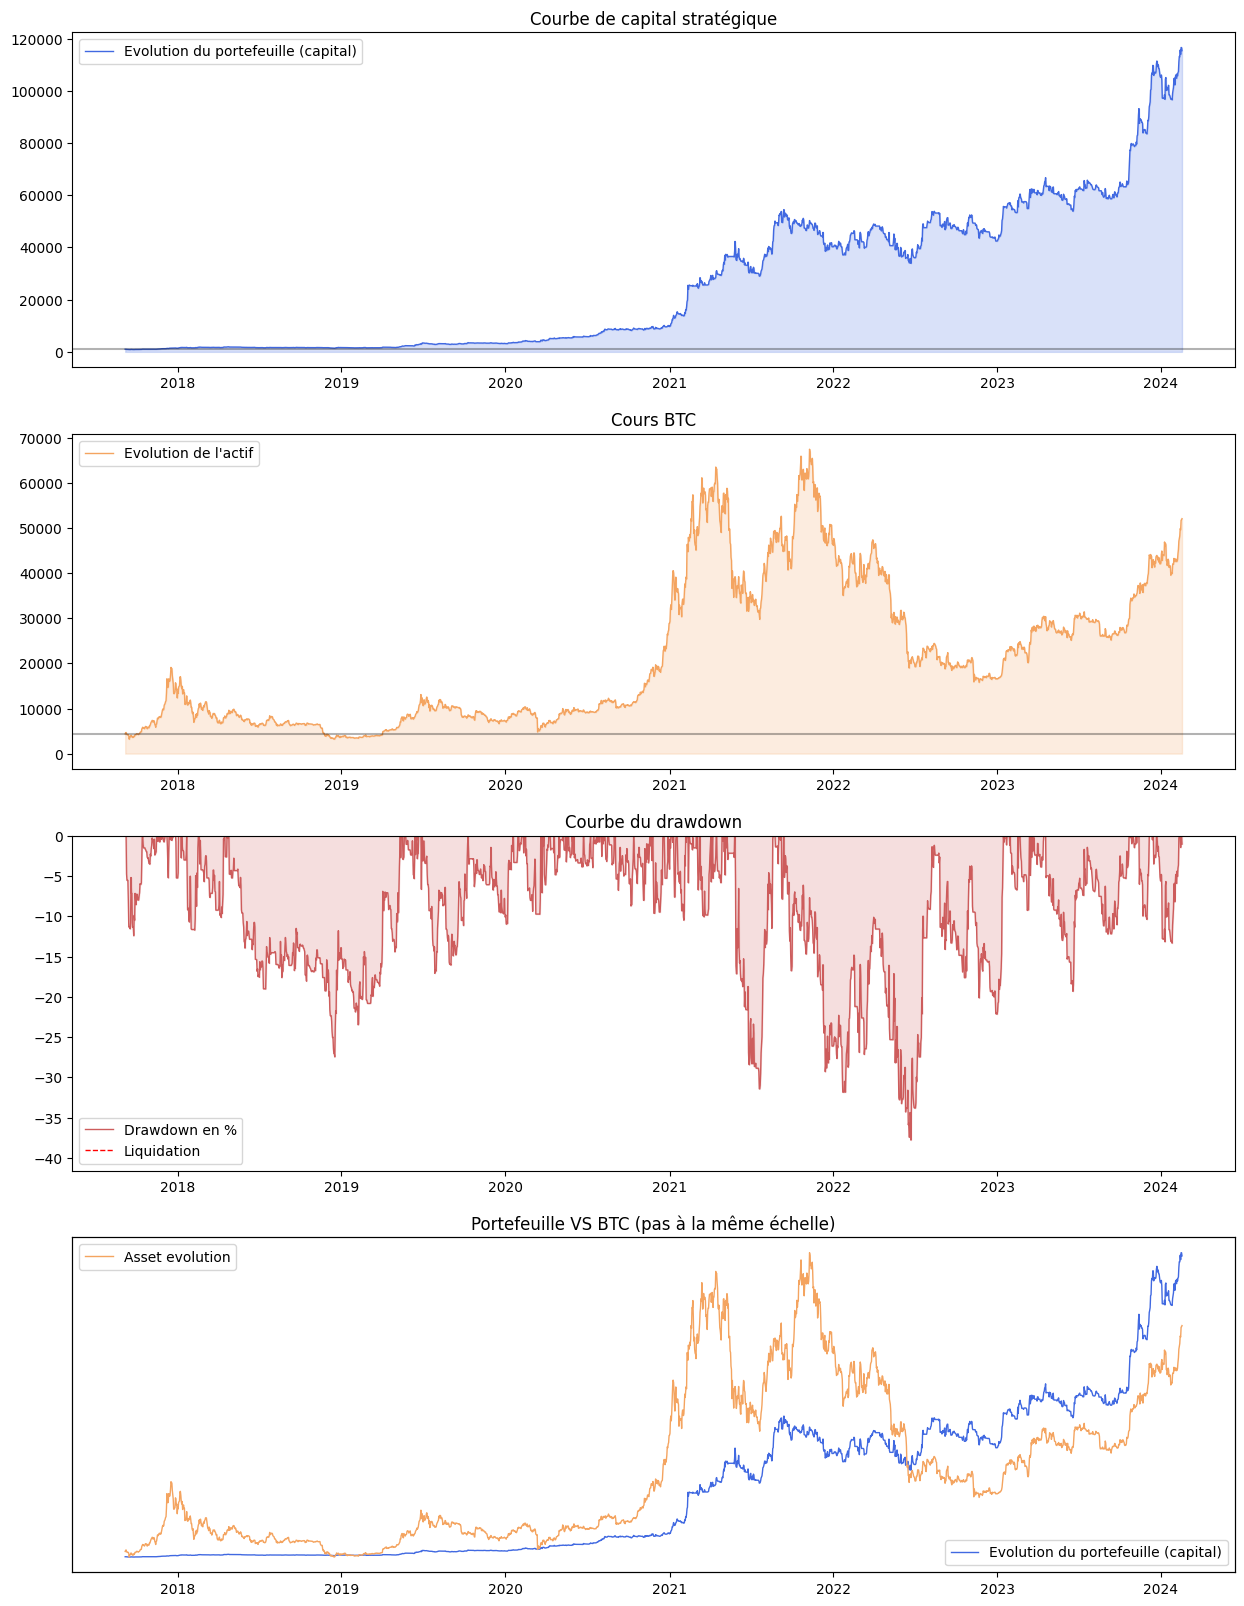

In [14]:
plot_equity_vs_asset(df_days=df_days.loc[:], pair=oldest_pair)

----- 2017 Cumulative Performances: 40.7% -----


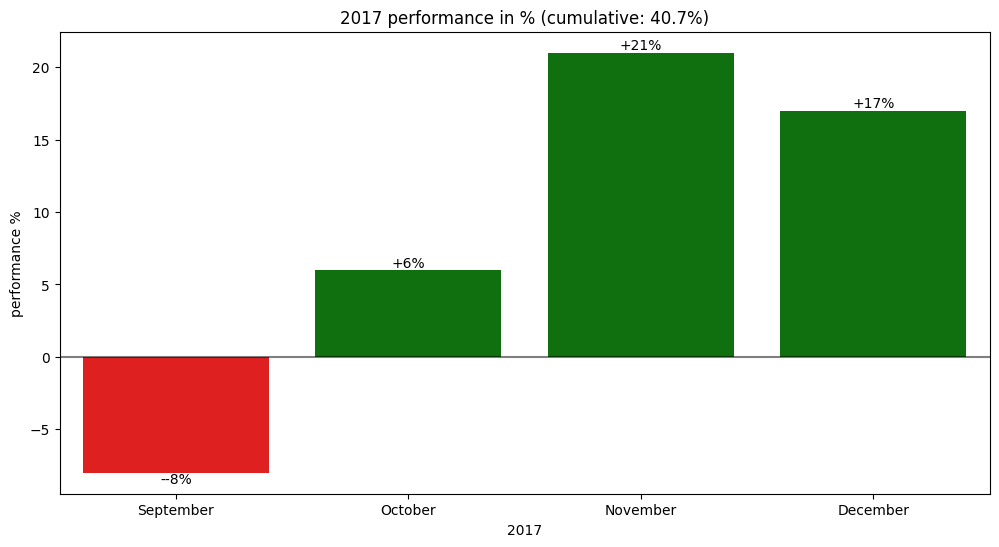

----- 2018 Cumulative Performances: 18.47% -----


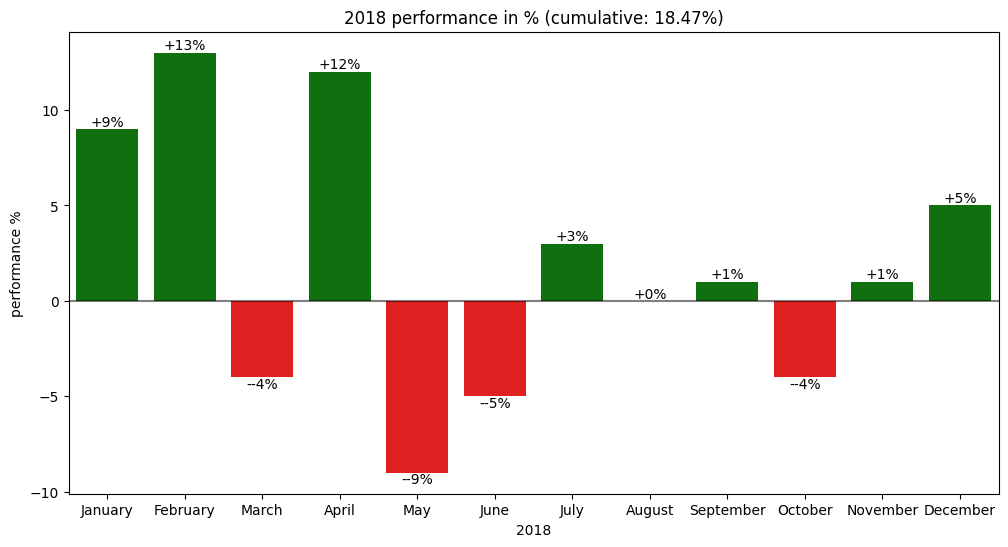

----- 2019 Cumulative Performances: 95.26% -----


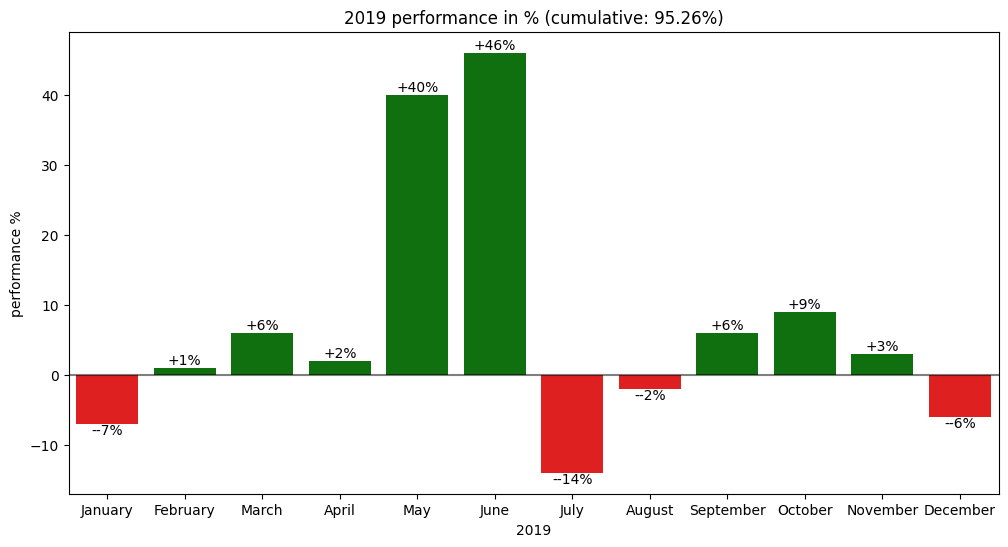

----- 2020 Cumulative Performances: 208.71% -----


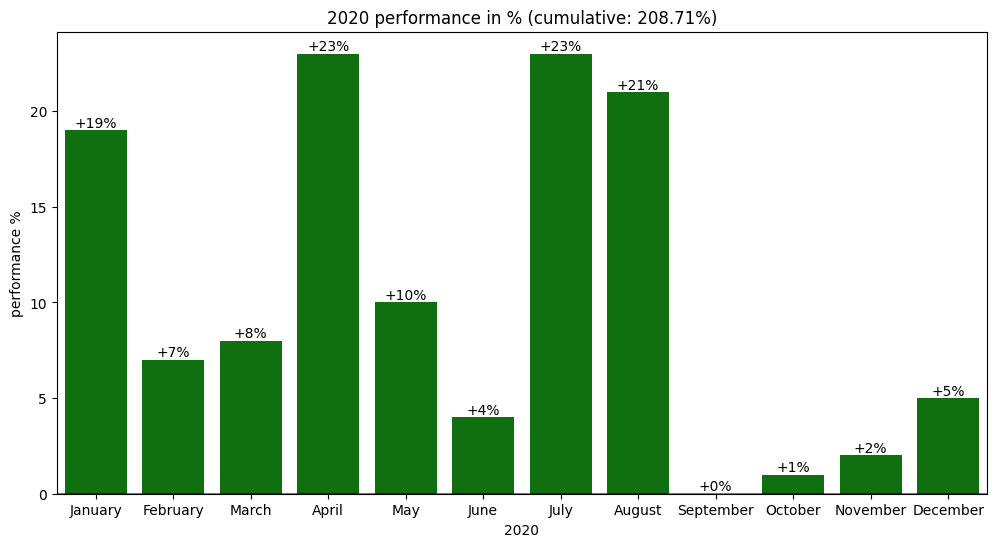

----- 2021 Cumulative Performances: 314.77% -----


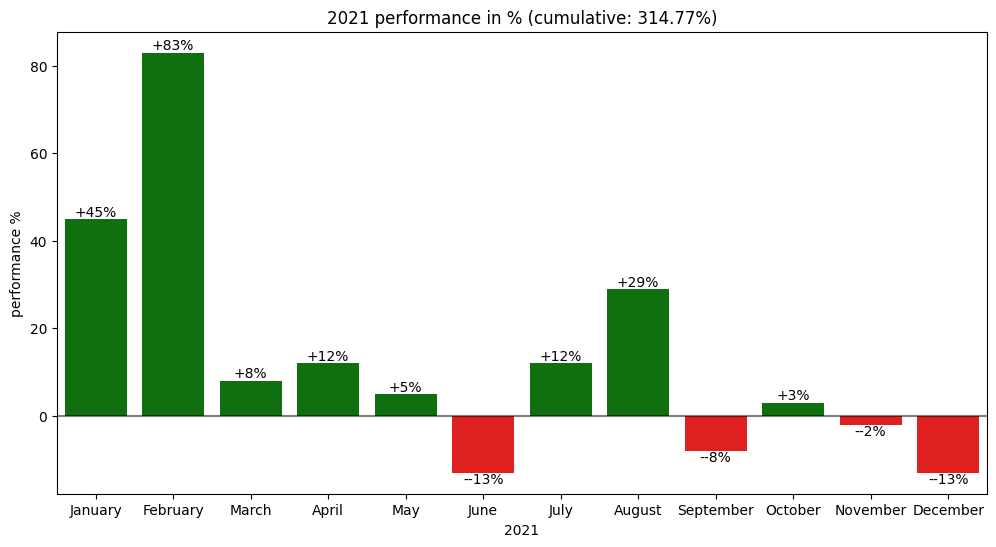

----- 2022 Cumulative Performances: 5.52% -----


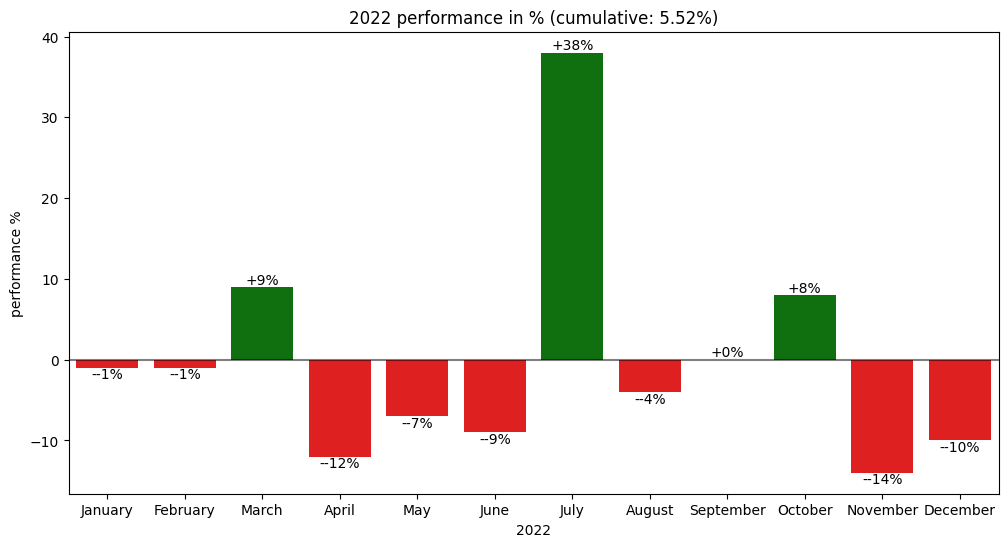

----- 2023 Cumulative Performances: 147.98% -----


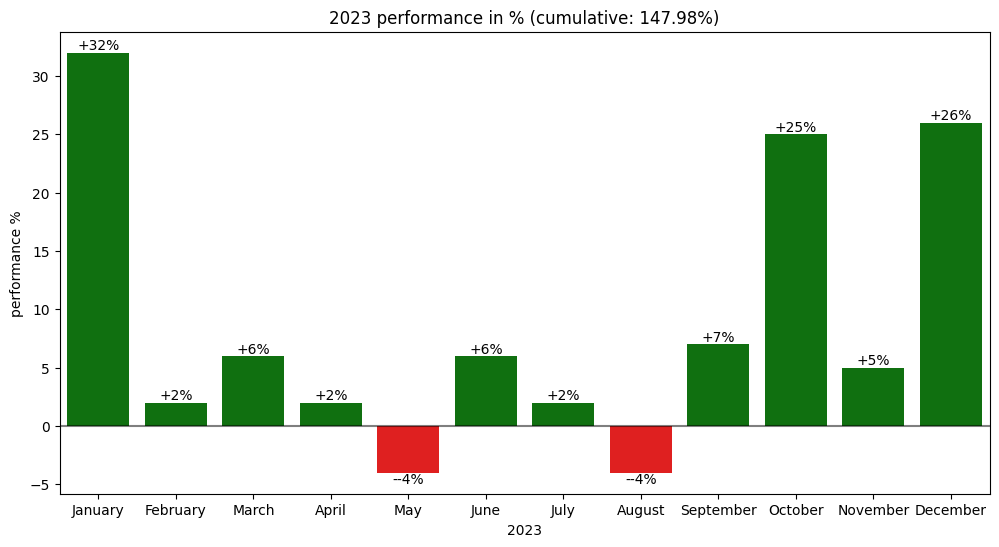

----- 2024 Cumulative Performances: 9.7% -----


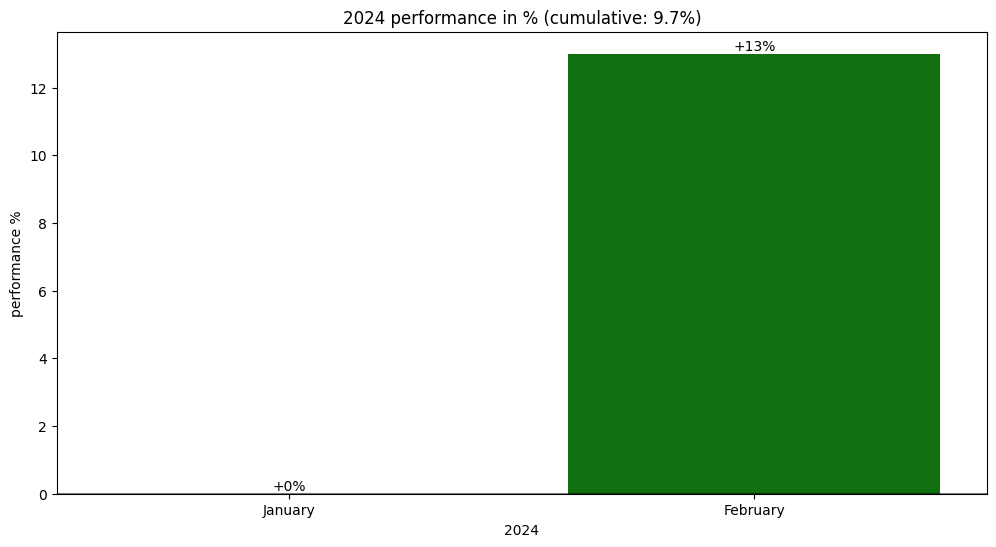

In [8]:
plot_bar_by_month(df_days=df_days)

In [13]:
df_trades.sort_values(by=["trade_result_pct"])

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2019-02-24 04:00:00,ETH/USDT,2019-02-24 04:00:00,2019-02-24 16:00:00,LONG,Market,Market,164.1700,138.9400,0.368323,0.103844,613.503511,519.218967,1708.425931,-94.652867,-0.154283,-0.058653,0 days 12:00:00,2309.918225,601.492294,0.260395
2017-09-12 04:00:00,ETH/USDT,2017-09-12 04:00:00,2017-09-13 12:00:00,LONG,Market,Market,314.1500,266.9300,0.184243,0.052152,306.887661,260.759266,855.189768,-46.312638,-0.150911,-0.057255,1 days 08:00:00,972.597747,117.407980,0.120716
2021-09-05 16:00:00,LINK/USDT,2021-09-05 16:00:00,2021-09-08 00:00:00,LONG,Market,Market,32.8400,28.0300,9.694041,2.756404,16147.040643,13782.020379,45036.318776,-2374.714306,-0.147068,-0.055664,2 days 08:00:00,48998.687705,3962.368929,0.080867
2019-07-13 16:00:00,LINK/USDT,2019-07-13 16:00:00,2019-07-14 20:00:00,LONG,Market,Market,3.2289,2.7856,0.859757,0.247092,1432.068439,1235.457848,4144.489215,-197.470348,-0.137892,-0.050030,1 days 04:00:00,4675.914086,531.424871,0.113652
2021-08-16 08:00:00,LINK/USDT,2021-08-16 08:00:00,2021-08-18 00:00:00,LONG,Market,Market,30.2920,26.2180,9.406073,2.712052,15667.381552,13560.260449,45386.177816,-2116.527175,-0.135091,-0.048915,1 days 16:00:00,48998.687705,3612.509889,0.073727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-16 04:00:00,ETH/USDT,2018-12-16 04:00:00,2018-12-26 00:00:00,LONG,Market,Market,86.1100,131.9000,0.303568,0.154905,505.642719,774.524151,1880.331852,268.577864,0.531161,0.124983,9 days 20:00:00,2309.918225,429.586373,0.185975
2019-06-11 04:00:00,LINK/USDT,2019-06-11 04:00:00,2019-06-17 08:00:00,LONG,Market,Market,1.1681,1.8791,0.552886,0.296295,920.924239,1481.473108,3350.949169,559.995983,0.608080,0.143187,6 days 04:00:00,3350.949169,0.000000,0.000000
2018-01-01 08:00:00,ETH/USDT,2018-01-01 08:00:00,2018-01-11 12:00:00,LONG,Market,Market,741.0100,1225.0000,0.306992,0.169067,511.347007,845.332835,1924.473420,333.678835,0.652549,0.147766,10 days 04:00:00,1924.473420,0.000000,0.000000
